In [14]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [4]:
#Connect to the database
conn_string = "host='localhost' dbname='phone_usage_db' user='postgres' password='postgres'"
conn = psycopg2.connect(conn_string)

print("Database opened successfully")
cursor = conn.cursor();
query = 'select * from phone_user_behavior'
cursor.execute(query)

colnames = [desc[0] for desc in cursor.description]


print(colnames)


phone_df = pd.DataFrame(cursor.fetchall(), columns=colnames)

conn.close()

print("Database Closed successfully")

Database opened successfully
['user_id', 'device_model', 'operating_system', 'app_usage_minutes_per_day', 'screen_time_hours_per_day', 'battery_drain_mah_per_day', 'number_of_apps_installed', 'data_usage_mb_per_day', 'age', 'gender', 'user_behavior_class']
Database Closed successfully


Battery Drain (mah/day) Per per Age Group

In [5]:
#Copy the database
phone_df_battery = phone_df.copy()
phone_df_battery.head()

,user_id,device_model,operating_system,app_usage_minutes_per_day,screen_time_hours_per_day,battery_drain_mah_per_day,number_of_apps_installed,data_usage_mb_per_day,age,gender,user_behavior_class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [7]:
#Create age groups
bins = [18,25,35,50]
labels = ["18-25","25-35","35-50"]
phone_df_battery['age_groups'] = pd.cut(phone_df_battery['age'], bins, labels=labels)

phone_df_battery.head()



,user_id,device_model,operating_system,app_usage_minutes_per_day,screen_time_hours_per_day,battery_drain_mah_per_day,number_of_apps_installed,data_usage_mb_per_day,age,gender,user_behavior_class,age_groups
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4,35-50
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3,35-50
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2,35-50
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3,18-25
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3,25-35


In [23]:
mean_battery_age = phone_df_battery.groupby(["age_groups"])["battery_drain_mah_per_day"].mean()
median_battery_age = phone_df_battery.groupby(["age_groups"])["battery_drain_mah_per_day"].median()




    

C:\Users\didem\AppData\Local\Temp\ipykernel_12188\561112450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_battery_age = phone_df_battery.groupby(["age_groups"])["battery_drain_mah_per_day"].mean()
C:\Users\didem\AppData\Local\Temp\ipykernel_12188\561112450.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_battery_age = phone_df_battery.groupby(["age_groups"])["battery_drain_mah_per_day"].median()


In [9]:
mean_battery_age

age_groups
18-25    1629.108333
25-35    1465.034091
35-50    1500.106838
Name: battery_drain_mah_per_day, dtype: float64

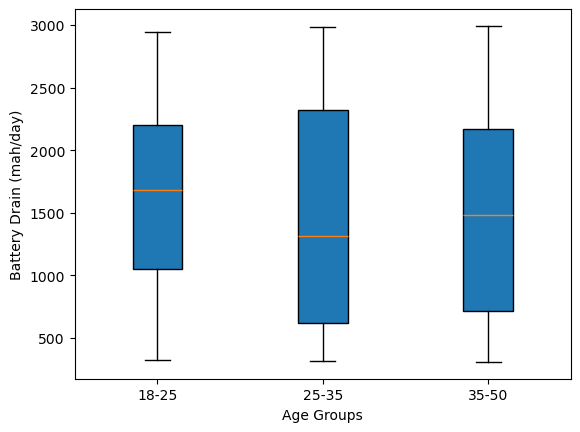

3     1676
6     1802
11    1690
22    2094
29    1899
Name: battery_drain_mah_per_day, dtype: int64

In [74]:
#Box plots to determine outliers 


age_column = ["18-25","25-35","35-50"]


first = []
second = []
third = []


first = phone_df_battery.loc[phone_df_battery["age_groups"] == "18-25", 'battery_drain_mah_per_day']
second = phone_df_battery.loc[phone_df_battery["age_groups"] == "25-35", 'battery_drain_mah_per_day']
third  = phone_df_battery.loc[phone_df_battery["age_groups"] == "35-50", 'battery_drain_mah_per_day']


battery_age_data = [first, second, third]

# Multiple box plots on one Axes
fig,ax = plt.subplots()
labels_bp= ["18-25","25-35","35-50"]
boxplot = ax.boxplot(battery_age_data, patch_artist=True,
                   labels=labels_bp)
ax.set_xlabel("Age Groups")
ax.set_ylabel('Battery Drain (mah/day)')
plt.show()



In [15]:
# Define treatment list
age_column = ["18-25","25-35","35-50"]

# Initialize list for tumor volumes
battery_drain_list = []

# Calculate IQR and identify potential outliers for each treatment
for item in age_column:
    # Filter data for each item
    battery_drain_level = phone_df_battery.loc[phone_df_battery["age_groups"] == item, 'battery_drain_mah_per_day']
    # Append filtered data to list
    battery_drain_list.append(battery_drain_level)
    # Calculate quartiles and IQR
    quartiles = battery_drain_level.quantile([.25, .5, .75])
    lq = quartiles[0.25]
    uq = quartiles[0.75]
    iqr = uq - lq
    # Determine bounds for potential outliers
    lower_bound = lq - (1.5 * iqr)
    upper_bound = uq + (1.5 * iqr)
    # Identify outliers
    outliers = battery_drain_level.loc[(battery_drain_level < lower_bound) | (battery_drain_level > upper_bound)]
    print(f"{item} age group's potential outliers: {outliers}")

18-25 age group's potential outliers: Series([], Name: battery_drain_mah_per_day, dtype: int64)
25-35 age group's potential outliers: Series([], Name: battery_drain_mah_per_day, dtype: int64)
35-50 age group's potential outliers: Series([], Name: battery_drain_mah_per_day, dtype: int64)


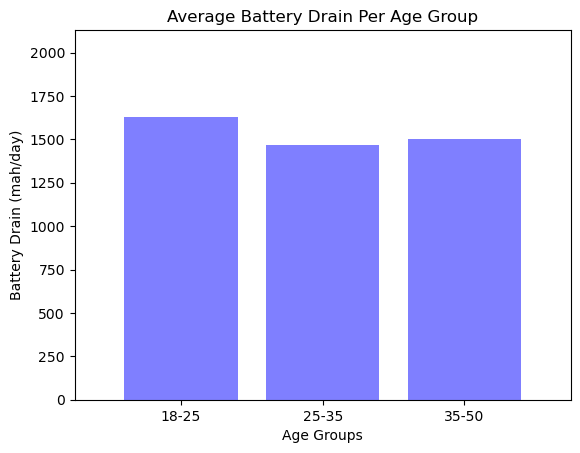

<Figure size 1000x600 with 0 Axes>

In [96]:
#Bar chart for Average Battery Drain vs. Age 
mean_battery_age_df = pd.DataFrame({"average_battery_drain": mean_battery_age})
reset_df_battery = mean_battery_age_df.reset_index()
reset_df_battery["average_battery_drain"].astype(int)
x_axis = np.arange(len(mean_battery_age))
plt.bar(x_axis, reset_df_battery["average_battery_drain"], color ='blue', alpha=0.5, align="center")
plt.xlim(-0.75,len(x_axis)-0.25)
plt.ylim(0,max(mean_battery_age)+500)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, reset_df_battery["age_groups"])
plt.title("Average Battery Drain Per Age Group")
plt.xlabel("Age Groups")
plt.ylabel("Battery Drain (mah/day)")
plt.figure(figsize=(10, 6)) 
plt.show()


Overall Phone Type Usage per Age Group

C:\Users\didem\AppData\Local\Temp\ipykernel_12188\2151374408.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phone_type_counts = phone_df_battery.groupby(["age_groups"])["device_model"].value_counts()


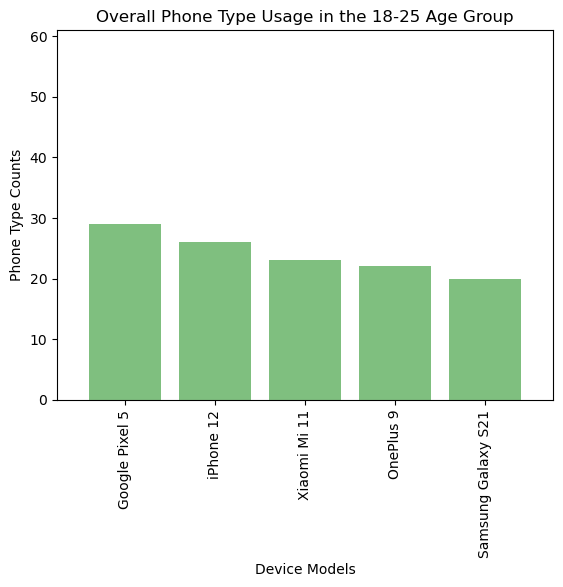

<Figure size 2000x800 with 0 Axes>

In [104]:
#Bar chart for the 18-25 year-old group
phone_type_counts = phone_df_battery.groupby(["age_groups"])["device_model"].value_counts()
phone_type_counts_df = pd.DataFrame({"phone_type_counts_by_age": phone_type_counts})
reset_df_phone_type_counts = phone_type_counts_df.reset_index()
age_group_1 = reset_df_phone_type_counts.loc[reset_df_phone_type_counts["age_groups"] == "18-25", ['phone_type_counts_by_age',"device_model","age_groups"]]
age_group_1_df = pd.DataFrame(age_group_1)
x_axis = np.arange(len(age_group_1))
plt.bar(x_axis, age_group_1_df["phone_type_counts_by_age"], color = "green", alpha=0.5, align="center")
plt.xlim(-0.75,len(x_axis)-0.25)
plt.ylim(0,max(phone_type_counts) +5)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, age_group_1_df["device_model"], rotation = "vertical")
plt.title("Overall Phone Type Usage in the 18-25 Age Group")
plt.xlabel("Device Models")
plt.ylabel("Phone Type Counts")
plt.figure(figsize=(20, 8)) 
plt.show()


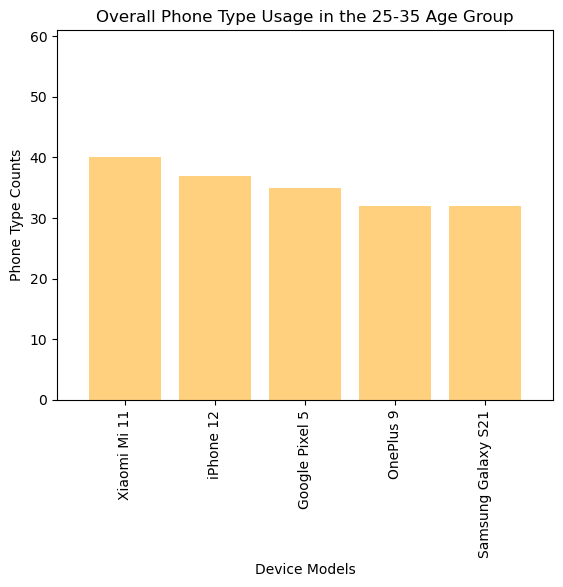

<Figure size 2000x800 with 0 Axes>

In [110]:
#Bar chart for the 25-35 age group
age_group_2 = reset_df_phone_type_counts.loc[reset_df_phone_type_counts["age_groups"] == "25-35", ['phone_type_counts_by_age',"device_model","age_groups"]]
age_group_2_df = pd.DataFrame(age_group_2)
x_axis = np.arange(len(age_group_2))
plt.bar(x_axis, age_group_2_df["phone_type_counts_by_age"], color = "orange", alpha=0.5, align="center")
plt.xlim(-0.75,len(x_axis)-0.25)
plt.ylim(0,max(phone_type_counts) +5)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, age_group_2_df["device_model"], rotation = "vertical")
plt.title("Overall Phone Type Usage in the 25-35 Age Group")
plt.xlabel("Device Models")
plt.ylabel("Phone Type Counts")
plt.figure(figsize=(20, 8)) 
plt.show()

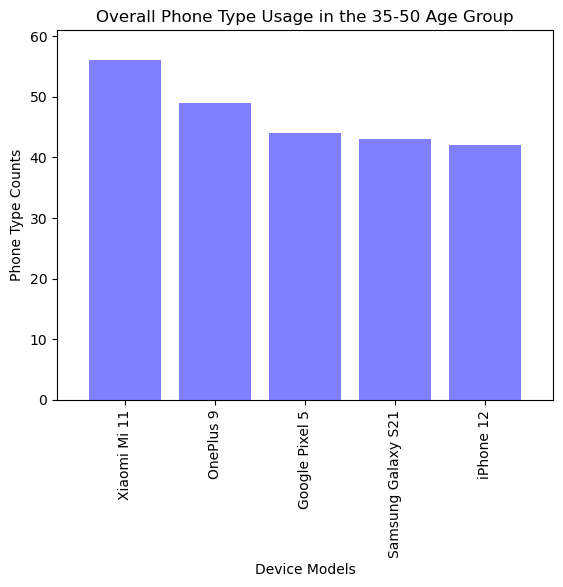

<Figure size 2000x800 with 0 Axes>

In [109]:
#Bar chart for the 35-50 age group
age_group_3 = reset_df_phone_type_counts.loc[reset_df_phone_type_counts["age_groups"] == "35-50", ['phone_type_counts_by_age',"device_model","age_groups"]]
age_group_3_df = pd.DataFrame(age_group_3)
x_axis = np.arange(len(age_group_3))
plt.bar(x_axis, age_group_3_df["phone_type_counts_by_age"], color = "blue", alpha=0.5, align="center")
plt.xlim(-0.75,len(x_axis)-0.25)
plt.ylim(0,max(phone_type_counts) +5)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, age_group_3_df["device_model"], rotation = "vertical")
plt.title("Overall Phone Type Usage in the 35-50 Age Group")
plt.xlabel("Device Models")
plt.ylabel("Phone Type Counts")
plt.figure(figsize=(20, 8)) 
plt.show()